In [109]:
import dataprocess as dp
import transformers
from sklearn.model_selection import train_test_split
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR
from modelhelper import MSE_Vec_matrix,gen_MSE_Vec
import modelhelper

#TODO Normalize Xtest
#Make our own loss function

# Hyperparameters
# Batch Size, Num Epochs, Learning Rate, Momentum, FC Layer, Activation Function


# 0 Lowercase & N2W
# 1 Contractions
# 2 Remove Punctutations
# 3 Strop Words

num_training = 1000000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def accuracy(net, input_id, labels):
    j = len(labels)

    guesses = torch.argsort(net(input_id), dim=1, descending=True)
#     print("GUESS: ", guesses[:,0])

    # guess1 = torch.argmax(guesses, dim=1)
    # guess2 = torch.argsort(guesses, dim=1)[-2]


    # current_real = torch.tensor(labels)
    current_real = labels.clone().detach()
#     print("LABEL: ", current_real)

    top1_acc = torch.sum(current_real==guesses[:,0])
    top2_acc = torch.sum(current_real==guesses[:,1])


    # print(guesses[:100])
    # print(current_real[:100])
    # print("Guess: ", guesses, "Label: ", current_real)

    accuracy_1 = top1_acc / j
    accuracy_2 = (top2_acc + top1_acc) / j
    # print(running_acc)
    # print(j)

#     print('Accuracy for top 1: %d %%' % ((accuracy_1) * 100.0))
#     print('Accuracy for top 2: %d %%' % ((accuracy_2) * 100.0))

    return accuracy_1, accuracy_2

    

In [110]:
# !cd GitHub/EC523_Project/
# !pip install transformers
!pip install --upgrade pylzma

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/share/pkg.7/python3/3.6.9/install/bin/python3.6 -m pip install --upgrade pip' command.


In [4]:
data = dp.unpickle_data(r"reviews_Electronics_5_7_encoded.pickle")

In [111]:
sentences = data['reviewText'][:num_training]
labels = data['overall'][:num_training]
print(sentences.shape)
print(len(labels))

torch.Size([1000000, 768])
1000000


In [112]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.1, random_state=42, stratify=labels)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

print(device)

X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

for i in range(len(y_test)):
    y_test[i] = y_test[i] - 1 

print(y_test)

# indecies = torch.permute(indecies)
# X_train = X_train[indexes,:]

X_train = X_train.clone().detach()
y_train = torch.tensor(y_train)

cuda


/share/pkg.7/python3/3.6.9/install/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


RuntimeError: CUDA error: device-side assert triggered

In [77]:
rev1 = X_train[y_train==1]
rev2 = X_train[y_train==2]
rev3 = X_train[y_train==3]
rev4 = X_train[y_train==4]
rev5 = X_train[y_train==5]

training_points = min(len(rev1), len(rev2), len(rev3), len(rev4), len(rev5))

rev1 = rev1 [:training_points]
rev2 = rev2 [:training_points]
rev3 = rev3 [:training_points]
rev4 = rev4 [:training_points]
rev5 = rev5 [:training_points]

indicies = torch.randperm(training_points * 5)

X_train = torch.cat((rev1, rev2, rev3, rev4, rev5), dim=0)[indicies, :]
base = torch.zeros(training_points)
y_train = torch.cat((base,base+1,base+2,base+3,base+4))[indicies]


In [79]:
class Net(nn.Module):
    def __init__(self, output_dim=5, dropout=0.5,activation=F.sigmoid):

        # self.loss = torch.nn.MSELoss()
        super(Net, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.activation = activation
        self.fc1 = nn.Linear(768, 600)
        self.fc2 = nn.Linear(600, 550)
        self.fc3 = nn.Linear(550, 500)
        self.fc4 = nn.Linear(500, 450)
        self.fc5 = nn.Linear(450, 400)
        self.fc6 = nn.Linear(400, 300)
        self.fc7 = nn.Linear(300, 200)
        self.fc8 = nn.Linear(200, 100)
        self.fc9 = nn.Linear(100, 50)
        self.fc10 = nn.Linear(50, output_dim)

    #def forward(self, input_id, mask):
    def forward(self, X_train):
        activation = self.activation
        x = self.dropout(X_train)
        x = activation(self.fc1(x))
        x = activation(self.fc2(x))
        x = activation(self.fc3(x))
        x = activation(self.fc4(x))
        x = activation(self.fc5(x))
        x = activation(self.fc6(x))
        x = activation(self.fc7(x))
        x = activation(self.fc8(x))
        x = activation(self.fc9(x))
        x = F.softmax(self.fc10(x), dim=1)
        return x

In [98]:
from importlib import reload
import modelhelper.MSE_Vec as test
reload(modelhelper.MSE_Vec)

# criterion = torch.nn.MSELoss().to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)
NUM_EPOCH = 200
LR_START  = 1e-3
LR_END    = 1e-3
LR_GAMMA  = (LR_END/LR_START)**(1/NUM_EPOCH)

net = Net(output_dim=5,dropout=0, activation=F.relu).to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=LR_START, momentum=0.9)
# optimizer = torch.optim.SGD(net.parameters(), lr=LR_START, momentum=0.8)
# criterion = torch.nn.CrossEntropyLoss().to(device)
criterion = torch.nn.MSELoss().to(device)
scheduler = ExponentialLR(optimizer, gamma=LR_GAMMA)
MSE_vec   = test.MSE_Vec_matrix(edge=0.2)
MSE_vec.to(device)
print(MSE_vec)

tensor([[1.0000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.2000, 1.0000, 0.2000, 0.0000, 0.0000],
        [0.0000, 0.2000, 1.0000, 0.2000, 0.0000],
        [0.0000, 0.0000, 0.2000, 1.0000, 0.2000],
        [0.0000, 0.0000, 0.0000, 0.2000, 1.0000]], device='cuda:0')


In [102]:
X_train = X_train.to(device)
y_train = y_train.long().to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

$$
\gamma = \left( \frac{\alpha}{\beta} \right)^{\frac{1}{e}}
$$

gamma is decay rate

beta is start learning rate

alpha is ending learning rate

e is number of epochs

In [101]:
batch_size = 10000
indecies = torch.tensor(range(batch_size))

train_losses = []
test_losses = []
accuracy1 = []
accuracy2 = []
for epoch in range(NUM_EPOCH):
    running_loss = 0.0
    for i in range(len(y_train)//batch_size):
    #for i in range(1):
        select = batch_size * i + indecies
        optimizer.zero_grad()
        outputs = net(X_train[select,:])

        # MSE Loss
#         loss = criterion(outputs, gen_MSE_Vec(y_train[select],scale=4))
#         loss = criterion(outputs, F.one_hot(y_train[select].long(),num_classes=5).float())

        # Cross Entropy Loss
        loss = criterion(outputs, y_train[select])

        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
    with torch.no_grad():
#         training_loss = criterion(net(X_test),F.one_hot(y_test.long(),num_classes=5).float()).item()
        loss = criterion(outputs, y_test[select].long()).item()
        ac1,ac2 = accuracy(net, X_test, y_test)
        accuracy1.append(ac1.item())
        accuracy2.append(ac2.item())
    print('[%d] loss: %.3f \t test loss: %.3f \t test_ac1: %.2f \t test_ac2: %.2f' %
        (epoch + 1, running_loss, training_loss*10,ac1,ac2))
        
    train_losses.append(running_loss)
    test_losses.append(training_loss)
    running_loss = 0.0

    scheduler.step()
  

print('Finished Training')
plt.plot(train_losses)
plt.figure()
plt.plot(test_losses)
plt.figure()
plt.plot(accuracy1)
plt.figure()
plt.plot(accuracy2)


RuntimeError: cuda runtime error (710) : device-side assert triggered at /pytorch/aten/src/THC/generic/THCTensorMath.cu:26

In [85]:
max(accuracy1)

0

In [95]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import torch

def F_score(net, inputs, labels):
    y_pred = []
    y_true = []

    output = net(inputs)
    output = torch.argmax(output, dim=1).cpu().numpy()
    y_pred.extend(output)
    
    y_true.extend(labels.cpu().numpy())
    
    classes = ('1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars')
    cf_matrix = confusion_matrix(y_true, y_pred)
    #print(cf_matrix)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix)*10, index=[i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    sn.heatmap(df_cm, annot=True)
    plt.savefig('output.png')
    


[[    0     0     0     0  3444]
 [    0     0     0     0  2490]
 [    0     0     0     0  4162]
 [    0     0     0     0 10167]
 [    0     0     0     0 29737]]


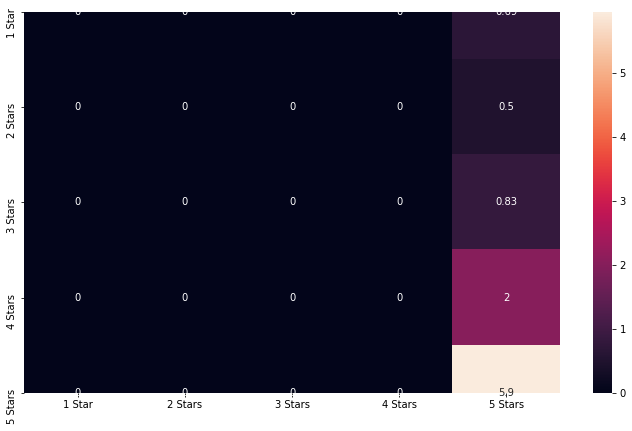

In [96]:
F_score(net, X_test, y_test)